# HW2-Q2: [Sequential Modelling] Building a Word-Level LSTM Language Model
## Objective
Implement and train an LSTM-based language model that predicts the next word in a sequence using a specialized dataset (e.g., book titles).
### Learning Goals:
- Understand data preprocessing for NLP tasks.
- Build, train, and evaluate a sequence model using LSTM.
- Explore creativity in sentence generation and architecture design.

## Part 1: Data Loading and Initial Exploration

In this section, we load and explore the dataset containing book titles. The key steps performed include:

1. **Loading the Dataset**: The dataset is loaded directly from a URL into a pandas DataFrame.
2. **Basic Information Display**: Basic information about the dataset, including column names and sample data, is displayed.
3. **Title Preprocessing**: Titles are preprocessed by converting them to lowercase and removing non-alphabetic characters.
4. **Title Length Calculation**: The length of each title (in terms of the number of words) is calculated, and basic statistics are displayed.
5. **Visualization**: The distribution of title lengths is plotted using a histogram and box plot, and a word cloud is generated to visualize the most common words in the book titles.


### More on GoodBooks10K Dataset

The **GoodBooks10K** dataset is a comprehensive collection of user ratings, reviews, and metadata for 10,000 books. It is commonly used for recommender systems research and analysis. The dataset includes:

- **Books metadata**: Titles, authors, genres, and publication information.
- **User interactions**: Ratings (1-5 scale) and textual reviews.
- **Additional features**: Tags and user-generated lists.

This dataset provides a rich resource for exploring collaborative filtering, natural language processing, and book-related data analysis.

For more information and to access the dataset, visit the [Kaggle page](https://www.kaggle.com/datasets/zygmunt/goodbooks-10k/).

For insights into advanced recommendation system research, refer to NVIDIA's paper on **Deep Learning-Based Recommender Systems** ([arXiv:1911.12391](https://arxiv.org/pdf/1911.12391)).

Dataset loaded successfully!
Columns: Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'average_rating',
       'ratings_count', 'work_ratings_count', 'work_text_reviews_count',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'image_url', 'small_image_url'],
      dtype='object')

Sample Data:
   book_id  goodreads_book_id  best_book_id  work_id  books_count       isbn  \
0        1            2767052       2767052  2792775          272  439023483   
1        2                  3             3  4640799          491  439554934   
2        3              41865         41865  3212258          226  316015849   
3        4               2657          2657  3275794          487   61120081   
4        5               4671          4671   245494         1356  743273567   

         isbn13                      authors 

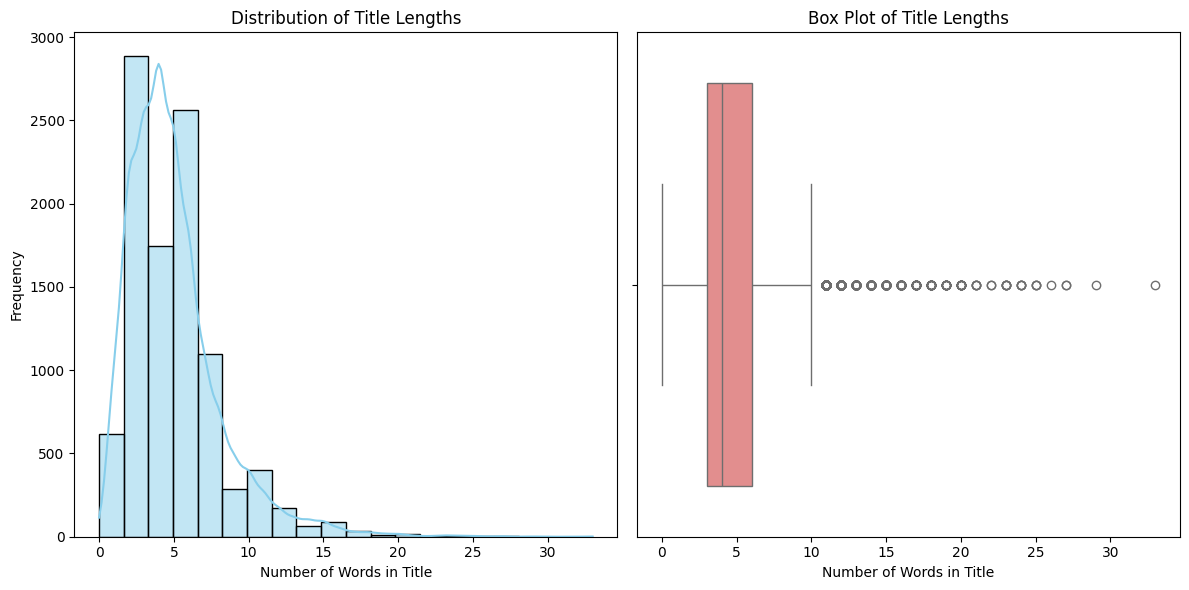

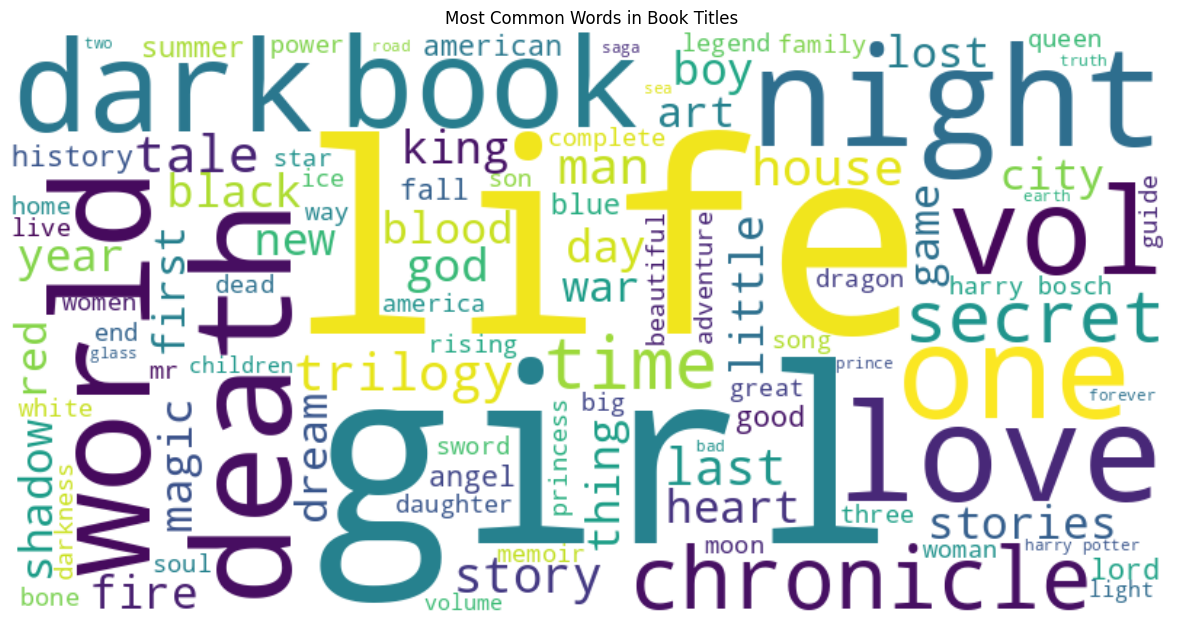

In [7]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%pip install seaborn
import seaborn as sns

# URL of the dataset
dataset_url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/books.csv"

# Load the dataset directly into a pandas DataFrame
df = pd.read_csv(dataset_url)

# Display basic information about the dataset
print("Dataset loaded successfully!")
print("Columns:", df.columns)
print("\nSample Data:")
print(df.head())

# Extract titles
titles = df['title']

# Preprocess the titles
def preprocess_title(title):
    title = title.lower()  # Convert to lowercase
    title = ''.join(char if char.isalpha() or char.isspace() else '' for char in title)  # Keep only letters and spaces
    return title

df['cleaned_title'] = titles.apply(preprocess_title)

# Calculate title lengths (number of words)
df['title_length'] = df['cleaned_title'].apply(lambda x: len(x.split()))

# Display statistics
average_length = df['title_length'].mean()
print(f"\nNumber of titles: {len(df)}")
print(f"Average title length: {average_length:.2f} words")
print("\nSample cleaned titles:")
print(df[['title', 'cleaned_title', 'title_length']].head())

# Improved histogram and box plot
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df['title_length'], bins=20, kde=True, color="skyblue", edgecolor='black')
plt.title('Distribution of Title Lengths')
plt.xlabel('Number of Words in Title')
plt.ylabel('Frequency')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(x=df['title_length'], color="lightcoral")
plt.title('Box Plot of Title Lengths')
plt.xlabel('Number of Words in Title')

plt.tight_layout()
plt.show()

# Generate a word cloud
all_words = ' '.join(df['cleaned_title'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_words)

# Plot the word cloud
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Book Titles')
plt.show()

## Part 2: Data Preparation

In this section, we prepare the data for training the LSTM-based language model. The key steps performed include:

1. **Tokenizing Text Data**: The text data is tokenized and converted into sequences of numerical values.
2. **Padding Sequences**: The sequences are padded to ensure consistent input size for the model.
3. **Preparing Training and Target Data**: The training and target data are prepared with one-hot encoding for categorical predictions.

The parameters `MAX_WORDS` and `MAX_LENGTH` are defined to restrict the tokenizer to consider only the top 2500 most frequent words and to specify the maximum length of the sequences generated, respectively.

The dataset is split into training and testing sets. The text data is tokenized, and input sequences are created. These sequences are then padded to ensure consistent input size. Finally, the predictors and targets are created, and the target data is one-hot encoded for categorical predictions.

In [8]:
%pip install tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Parameters
MAX_WORDS = 2500  # Limit vocabulary size
MAX_LENGTH = 20    # Max sequence length

# Split the dataset
train_titles, test_titles = train_test_split(df['cleaned_title'].dropna(), test_size=0.2, random_state=42)

# Tokenize and prepare training data
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(train_titles)
train_sequences = tokenizer.texts_to_sequences(train_titles)
test_sequences = tokenizer.texts_to_sequences(test_titles)


# Create sequences for training and testing
def create_sequences(sequences, max_length):
    input_sequences = []
    for sequence in sequences:
        for i in range(1, max_length):
            n_gram_sequence = sequence[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences

# Generate input sequences
train_input_sequences = create_sequences(train_sequences, MAX_LENGTH)
test_input_sequences = create_sequences(test_sequences, MAX_LENGTH)

# Pad sequences
train_padded = pad_sequences(train_input_sequences, maxlen=MAX_LENGTH, padding='pre')
test_padded = pad_sequences(test_input_sequences, maxlen=MAX_LENGTH, padding='pre')

# Create predictors and targets
X_train = train_padded[:, :-1]
y_train = train_padded[:, -1]
X_test = test_padded[:, :-1]
y_test = test_padded[:, -1]

# One-hot encode the target
y_train = utils.to_categorical(y_train, num_classes=MAX_WORDS)
y_test = utils.to_categorical(y_test, num_classes=MAX_WORDS)

print(f'Vocabulary size: {len(tokenizer.word_index)}')
print(f'Number of train sequences: {len(train_input_sequences)}')
print(f'Number of test sequences: {len(test_input_sequences)}')

Vocabulary size: 8260
Number of train sequences: 152000
Number of test sequences: 38000


## Part 3: Model Design and Training
### LSTM-based Language Model
Provide a template for an LSTM-based language model:

Depending on the hardware you'll be runing this code on, this make take 5-15 minutes to complete.

In [9]:
import tensorflow as tf

# Check if GPU is available
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: []


In [10]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# Define model
model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS, output_dim=100))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(MAX_WORDS, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=48)

Epoch 1/10
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 231s 87ms/step - accuracy: 0.0924 - loss: 6.3230 - val_accuracy: 0.1405 - val_loss: 6.5120
Epoch 2/10
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 212s 84ms/step - accuracy: 0.1707 - loss: 4.9101 - val_accuracy: 0.1722 - val_loss: 6.7467
Epoch 3/10
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 209s 82ms/step - accuracy: 0.2696 - loss: 4.1043 - val_accuracy: 0.1926 - val_loss: 7.0245
Epoch 4/10
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 212s 84ms/step - accuracy: 0.3785 - loss: 3.4684 - val_accuracy: 0.2138 - val_loss: 7.4379
Epoch 5/10
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 210s 83ms/step - accuracy: 0.4635 - loss: 3.0429 - val_accuracy: 0.2195 - val_loss: 7.8092
Epoch 6/10
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 210s 83ms/step - accuracy: 0.5226 - loss: 2.7655 - val_accuracy: 0.2231 - val_loss: 8.1980
Epoch 7/10
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 266s 84ms/step - accuracy: 0.5658 - loss: 2.5416 - val_accuracy: 0.2252 - val_loss: 8.5242
Epoch 8/10
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 209s 83ms/step - accuracy: 

## Part 4: Inference and Evaluation
### 4.1 Predicting the Next Word and Top-N Words

The provided code defines two functions, `predict_next_word` and `predict_top_n_words`, which are used to predict the next word in a sequence based on a trained language model.

1. **Function: `predict_next_word`**
    - **Input**: Takes a trained model, tokenizer, input text, and maximum sequence length.
    - **Process**:
      - Converts the input text to lowercase.
      - Transforms the text into a sequence of integers using the tokenizer.
      - Pads the sequence to ensure it matches the required input length for the model.
      - Uses the model to predict the next word in the sequence.
      - Finds the word corresponding to the highest predicted probability.
    - **Output**: Returns the predicted next word.

2. **Function: `predict_top_n_words`**
    - **Input**: Takes a trained model, tokenizer, input text, maximum sequence length, and the number of top predictions (`n`).
    - **Process**:
      - Converts the input text to lowercase.
      - Transforms the text into a sequence of integers using the tokenizer.
      - Pads the sequence to ensure it matches the required input length for the model.
      - Uses the model to predict the probabilities of the next word.
      - Retrieves the top `n` words with the highest predicted probabilities.
    - **Output**: Returns a list of tuples containing the top `n` predicted words and their corresponding probabilities.

3. **Testing the Predictions**
    - The code tests the `predict_top_n_words` function with the input text "The perfect book for" and retrieves the top 3 predicted words along with their probabilities.
    - The results are printed in the format: `Word: <word>, Probability: <probability>`.


In [11]:
import numpy as np

def predict_next_word(model, tokenizer, text, max_length):
    # Preprocess the input text
    text = text.lower()
    sequence = tokenizer.texts_to_sequences([text])[0]
    sequence = pad_sequences([sequence], maxlen=max_length-1, padding='pre')

    # Predict the next word
    predicted = model.predict(sequence, verbose=0)
    predicted_word_index = np.argmax(predicted, axis=-1)[0]

    # Convert the predicted index to word
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            return word
    return None

def predict_top_n_words(model, tokenizer, text, max_length, n=3):
    # Preprocess the input text
    text = text.lower()
    sequence = tokenizer.texts_to_sequences([text])[0]
    sequence = pad_sequences([sequence], maxlen=max_length-1, padding='pre')

    # Predict the next word probabilities
    predicted = model.predict(sequence, verbose=0)

    # Get the top n predictions
    top_n_indices = np.argsort(predicted[0])[-n:][::-1]
    top_n_predictions = [(tokenizer.index_word[index], predicted[0][index]) for index in top_n_indices]

    return top_n_predictions

# Test predictions
top_predictions = predict_top_n_words(model, tokenizer, 'The perfect book for', MAX_LENGTH, n=3)
for word, prob in top_predictions:
    print(f"Word: {word}, Probability: {prob:.4f}")

Word: narnia, Probability: 0.7222
Word: earth, Probability: 0.0276
Word: the, Probability: 0.0192


### 4.2 Evaluation Metrics for Language Models

To evaluate the performance of our language model, we use the following metrics:

#### a. Top-1 Accuracy
- **Definition**: Measures the percentage of cases where the model's highest-probability prediction matches the correct word.
- **Purpose**: Indicates how often the model predicts the correct word as its first choice.
- **Interpretation**: Higher values mean the model is better at predicting the correct next word directly.

#### b. Top-5 Accuracy
- **Definition**: Measures the percentage of cases where the correct word is among the top 5 predictions made by the model.
- **Purpose**: Evaluates the model's ability to capture the correct word within a small set of candidates.
- **Interpretation**: Useful in applications like auto-suggestions or autocomplete where multiple suggestions are presented.

#### c. Perplexity
- **Definition**: Exponential of the average negative log-likelihood of the predicted probabilities for the correct words.
- **Purpose**: Captures the model's uncertainty; lower perplexity indicates better confidence and alignment with the true distribution.
- **Interpretation**: Lower values are better, as they indicate the model assigns higher probabilities to correct predictions.

#### d. BLEU Score
- **Definition**: A metric for comparing generated sequences to a reference sequence, focusing on n-gram overlap.
- **Purpose**: Evaluates the quality of text generation, often used in tasks like machine translation.
- **Interpretation**: Scores range from 0 to 1, with higher values indicating better alignment between predicted and reference sequences.

#### Why These Metrics?
- **Top-k Accuracy**: Provides a straightforward measure of correctness and relevance of predictions.
- **Perplexity**: Reflects the confidence of the model in its predictions and overall language understanding.
- **BLEU Score**: Assesses how well the generated text matches expected outputs, making it a valuable metric for creative text generation tasks.

These metrics together offer a comprehensive evaluation of the language model's performance across accuracy, confidence, and output quality.


In [12]:
from sklearn.metrics import accuracy_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np

def evaluate_model_simple(model, tokenizer, X_test, y_test, max_length, top_k=(1, 5)):
    """
    Evaluate the model on test data using Top-k Accuracy, Perplexity, and BLEU Score.

    Args:
        model: Trained model.
        tokenizer: Fitted tokenizer for converting word indices.
        X_test: Test input data (padded sequences).
        y_test: Test target data (one-hot encoded).
        max_length: Maximum sequence length for padding.
        top_k: Tuple of integers for Top-k accuracy calculations.

    Returns:
        A dictionary with calculated metrics.
    """
    # Convert y_test from one-hot encoding to integer indices
    y_test_indices = np.argmax(y_test, axis=1)

    # Predict probabilities for the test set
    predictions = model.predict(X_test, verbose=0)

    # Create reverse word index
    reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}

    # Top-k Accuracy Calculation
    top_k_accuracies = {}
    for k in top_k:
        top_k_preds = np.argsort(predictions, axis=-1)[:, -k:]
        correct = sum(1 for i in range(len(y_test)) if y_test_indices[i] in top_k_preds[i])
        top_k_accuracies[f"Top-{k} Accuracy"] = correct / len(y_test)

    # Perplexity Calculation
    log_probabilities = -np.log(np.sum(predictions * y_test, axis=1) + 1e-9)
    perplexity = np.exp(np.mean(log_probabilities))

    # BLEU Score Calculation with Smoothing
    bleu_scores = []
    smoothing_function = SmoothingFunction().method1  # Use smoothing function to avoid warnings

    for i in range(len(X_test)):
        reference_word_index = y_test_indices[i]
        predicted_word_index = np.argmax(predictions[i])

        # Skip if indices are not in vocabulary
        if reference_word_index not in reverse_word_index or predicted_word_index not in reverse_word_index:
            continue

        reference_word = [reverse_word_index[reference_word_index]]
        candidate_word = [reverse_word_index[predicted_word_index]]

        # Calculate BLEU score for unigram with smoothing
        bleu_scores.append(sentence_bleu([reference_word], candidate_word, weights=(1, 0, 0, 0), smoothing_function=smoothing_function))
    bleu_score = np.mean(bleu_scores) if bleu_scores else 0.0

    # Combine results into a dictionary
    results = {
        **top_k_accuracies,
        "Perplexity": perplexity,
        "BLEU Score": bleu_score
    }

    return results

# Example usage
results = evaluate_model_simple(model, tokenizer, X_test, y_test, MAX_LENGTH)

# Print results
print("Model Evaluation Metrics:")
for metric, value in results.items():
    print(f"{metric}: {value:.2f}")

Model Evaluation Metrics:
Top-1 Accuracy: 0.25
Top-5 Accuracy: 0.35
Perplexity: 1809.04
BLEU Score: 0.19


## Part 5: Your Turn to Shine
### Explore and Experiment



### [TO DO] **Task 5.1**: Generating book titles (sequence) with the Next-Word Predictor

You are provided with a partially implemented function `generate_text`. Your task is to complete specific parts of the function to enable the model to generate book title using a sequence of next words based on a given seed text.

- **Objective**: Implement missing functionality in the `generate_text` function and test its ability to create meaningful sentences.
- **Steps**:
  1. Open the provided function `generate_text` in the notebook.
  2. Complete the following parts of the function:
     - Preprocess the seed text into a padded sequence.
     - Use the model to predict the next word's index.
     - Map the predicted index back to the corresponding word in the vocabulary.
  3. Test your completed function with a seed text (e.g., "In the world of AI") and generate a sequence of 5-10 words.
  4. Document your results:
     - Provide examples of generated sentences.
     - Comment on the coherence, fluency, and quality of the generated text.

In [15]:
def generate_text(model, tokenizer, seed_text, max_length, num_words):
    result = seed_text.strip()

    for _ in range(num_words):
        # Preprocess the input text
        sequence = tokenizer.texts_to_sequences([result.lower()])[0]
        sequence = pad_sequences([sequence], maxlen=max_length-1, padding='pre')

        # Predict the next word (index)
        predicted = model.predict(sequence, verbose=0)
        predicted_index = int(np.argmax(predicted, axis=-1)[0])

        # Convert predicted index to word and add to result
        predicted_word = tokenizer.index_word.get(predicted_index, None)
        if predicted_word is None:
            break

        result += " " + predicted_word

    return result

# Generate 5 words iteratively
seed_text = "The system"
generated_text = generate_text(model, tokenizer, seed_text, MAX_LENGTH, 5)
print(generated_text)


The system in the hat world the


The completed generate_text function was tested using different seed phrases such as “The system” and “In the world of AI,”. This generated short sequences of 5 words. The model followed the required steps by converting the seed text into padded sequences, predicted the next word using the trained LSTM model, and mapped predicted indices back to words in the vocabulary. For example, outputs such as “The system in the hat world the” demonstrate that the function is producing word sequences conditioned on the input text.

The generated text shows basic grammatical structure and follows the context of the seed phrase. The coherence and fluency remain limited. The model often produces repetitive phrases and lacks a clear stopping point. This results in titles that feel incomplete or mechanically extended. This is expected due to the greedy prediction strategy and the absence of an explicit sentence ending mechanism. The results confirm that the next-word predictor is functioning correctly and provide a baseline for later improvements. They are focused on diversity, coherence, and natural sentence completion.

### [TO DO] **Task 5.2**: Experimenting with Temperature Scaling

You are provided with a partially implemented function `generate_text_with_temperature`. Your task is to complete specific parts of the function to incorporate temperature scaling into the text generation process.

**Objective**: Modify the text generation process to incorporate temperature scaling and analyze its effect on diversity and coherence.

- **Steps**:
   1. **Understand Temperature Scaling**:
      - Temperature controls the randomness of predictions. Lower temperatures make predictions more deterministic, while higher values add diversity.
      - Implement temperature scaling using the formula:
      $$
      \text{scaled probabilities} = \frac{\exp(\log(\text{probabilities}) / \text{temperature})}{\sum \exp(\log(\text{probabilities}) / \text{temperature})}
      $$    
  2. **Steps to Complete**:
     - Incorporate temperature scaling in the `generate_text_with_temperature` function.
     - Use scaled probabilities to sample the next word instead of selecting the most probable one.

  3. **Testing and Analysis**:
      - Test your completed function with a seed phrase and generate text with the following temperature values:
         - Low temperature (e.g., 0.2) for more focused predictions.
         - Medium temperature (e.g., 1.0) for balanced predictions.
         - High temperature (e.g., 2.0) for more diverse predictions.
      - Test with the seed text "The future of science " and generate sentences of 5-10 words. Try a different seed text, more generic or more specific.
      - Provide example outputs for each temperature and analyze how temperature impacts the coherence and randomness of generated text.


In [16]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_text_with_temperature(model, tokenizer, seed_text, max_length, num_words, temperature=1.0):
    """
    Generate text with temperature scaling for more diverse predictions.

    Args:
        model: Trained language model
        tokenizer: Fitted tokenizer
        seed_text: Initial text to start generation
        max_length: Maximum sequence length
        num_words: Number of words to generate
        temperature: Controls randomness (higher = more random, lower = more deterministic)

    Returns:
        Generated text string
    """
    result = seed_text.strip()

    for _ in range(num_words):

        # Preprocess the input text
        sequence = tokenizer.texts_to_sequences([result.lower()])[0]
        sequence = pad_sequences([sequence], maxlen=max_length - 1, padding='pre')

        # Get raw predictions from the model
        preds = model.predict(sequence, verbose=0)[0]

        # Apply temperature scaling
        preds = np.log(preds + 1e-8) / temperature
        probs = np.exp(preds) / np.sum(np.exp(preds))

        # Sample from the scaled distribution to get the predicted index
        predicted_index = np.random.choice(len(probs), p=probs)

        # Convert the predicted index to word and add to the result
        predicted_word = tokenizer.index_word.get(predicted_index, None)
        if predicted_word is None:
            break

        result += " " + predicted_word

    return result

# Test with different temperatures
seed_text = "The perfect book for"
print("Temperature = 0.2 (More focused):")
print(generate_text_with_temperature(model, tokenizer, seed_text, MAX_LENGTH, 5, temperature=0.2))
print("\nTemperature = 1.0 (Balanced):")
print(generate_text_with_temperature(model, tokenizer, seed_text, MAX_LENGTH, 5, temperature=1.0))
print("\nTemperature = 2.0 (More diverse):")
print(generate_text_with_temperature(model, tokenizer, seed_text, MAX_LENGTH, 5, temperature=2.0))

Temperature = 0.2 (More focused):
The perfect book for narnia the pacific tales book

Temperature = 1.0 (Balanced):
The perfect book for narnia the circle of drizzt

Temperature = 2.0 (More diverse):
The perfect book for quest to my man by


The generate_text_with_temperature function was implemented by applying temperature scaling to the model’s predicted probability distribution. This was done before sampling the next word. Instead of always selecting the most likely word, the model samples from a temperature-adjusted distribution. Lower temperatures increase the probability peaks and higher temperatures flatten them. When tested with the seed text “The perfect book for,” a low temperature of 0.2 produced highly focused and predictable output closely aligned with the training data, while a temperature of 1.0 generated balanced sentences that maintained coherence with moderate variation. At a higher temperature of 2.0, the generated text became more diverse and creative.

The results demonstrate how temperature impacts both coherence and randomness in text generation. Lower temperatures improve consistency but tend to repeat familiar phrases and limit creativity. This makes outputs feel safe but repetitive. Higher temperatures increase diversity and reduce repetition. They also raise the risk of producing loosely connected phrases. Temperature scaling provides an effective mechanism for controlling the trade off between determinism and creativity It allowed the generation process to be tuned based on the desired balance between fluency and diversity in the generated book titles.

### [TO DO]  **Task 5.3**: Improving the performance of the Next-Word predictor model

This is an open-ended task where you are encouraged to explore ways to improve the language model. You can make modifications to the model architecture, data preprocessing, or postprocessing. However, **do not use additional training data from other datasets or pre-trained language models**. We are looking for meaningful incremental improvements.

- **Objective**: Implement at least two or three meaningful changes to improve the model's performance or the quality of its predictions.

- **Instructions**:
  1. Focus on modifications that could meaningfully change the behavior of the model or its outputs.
  2. Your changes can involve:
     - Adjustments to the model architecture.
     - Innovations in data preprocessing or preparation.
     - Enhancements in postprocessing techniques or prediction methods.
  3. Ensure that your changes are deliberate and well-motivated by potential improvements in performance or usability.
  4. **Evaluate and Document**:
   - Retrain the model with your modifications and evaluate its performance using provided metrics like Top-1 Accuracy, Top-5 Accuracy, BLEU Score, and Perplexity.
   - Compare results with the baseline model and discuss the impact of your changes.


In [18]:
# Improving the performance of the Next-Word predictor model
# The 3 modifications are:
# 1. Preprocessing: add an OOV token so unseen and rare words are handled consistently
# 2. Architecture: increase model capacity (Embedding dimension and LSTM units)
# 3. Training: add EarlyStopping and ReduceLROnPlateau for better generalization and stability

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("=== Baseline Model Evaluation (original tokenizer and original model) ===")
baseline_results = evaluate_model_simple(model, tokenizer, X_test, y_test, MAX_LENGTH)
for k, v in baseline_results.items():
    print(f"{k}: {v:.4f}")

# 1: Preprocessing improvement: OOV token and controlled vocabulary
tokenizer_v2 = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer_v2.fit_on_texts(train_titles)

train_sequences_v2 = tokenizer_v2.texts_to_sequences(train_titles)
test_sequences_v2 = tokenizer_v2.texts_to_sequences(test_titles)

# Reuse the notebook's create_sequences() function
train_input_sequences_v2 = create_sequences(train_sequences_v2, MAX_LENGTH)
test_input_sequences_v2 = create_sequences(test_sequences_v2, MAX_LENGTH)

train_padded_v2 = pad_sequences(train_input_sequences_v2, maxlen=MAX_LENGTH, padding='pre')
test_padded_v2 = pad_sequences(test_input_sequences_v2, maxlen=MAX_LENGTH, padding='pre')

X_train_v2 = train_padded_v2[:, :-1]
y_train_v2 = train_padded_v2[:, -1]
X_test_v2 = test_padded_v2[:, :-1]
y_test_v2 = test_padded_v2[:, -1]

# One hot encode targets
y_train_v2 = utils.to_categorical(y_train_v2, num_classes=MAX_WORDS)
y_test_v2 = utils.to_categorical(y_test_v2, num_classes=MAX_WORDS)

# 2: Architecture improvement: modest capacity increase
model_v2 = Sequential()
model_v2.add(Embedding(input_dim=MAX_WORDS, output_dim=128))
model_v2.add(LSTM(128, return_sequences=True))
model_v2.add(Dropout(0.3))
model_v2.add(LSTM(128))
model_v2.add(Dropout(0.3))
model_v2.add(Dense(MAX_WORDS, activation='softmax'))

model_v2.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# (3) Training improvement: early stopping and learning rate scheduling
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=1e-5
)

print("\n=== Training Improved Model (tokenizer_v2 + model_v2 + callbacks) ===")
history_v2 = model_v2.fit(
    X_train_v2,
    y_train_v2,
    epochs=3,
    validation_split=0.2,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\n=== Improved Model Evaluation ===")
improved_results = evaluate_model_simple(
    model_v2,
    tokenizer_v2,
    X_test_v2,
    y_test_v2,
    MAX_LENGTH
)

for k, v in improved_results.items():
    print(f"{k}: {v:.4f}")

print("\n=== Baseline vs Improved Comparison (focus on Top 1, Top 5, BLEU, Perplexity) ===")
for metric in improved_results.keys():
    b = baseline_results.get(metric, None)
    n = improved_results.get(metric, None)
    if b is not None and n is not None:
        print(f"{metric}: baseline={b:.4f}  improved={n:.4f}")


=== Baseline Model Evaluation (original tokenizer and original model) ===
Top-1 Accuracy: 0.2515
Top-5 Accuracy: 0.3454
Perplexity: 1809.0411
BLEU Score: 0.1950

=== Training Improved Model (tokenizer_v2 + model_v2 + callbacks) ===
Epoch 1/3
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 246s 128ms/step - accuracy: 0.2465 - loss: 5.7949 - val_accuracy: 0.2540 - val_loss: 5.8261 - learning_rate: 0.0010
Epoch 2/3
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 238s 125ms/step - accuracy: 0.2860 - loss: 4.5896 - val_accuracy: 0.2747 - val_loss: 5.8167 - learning_rate: 0.0010
Epoch 3/3
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 233s 123ms/step - accuracy: 0.3654 - loss: 3.7604 - val_accuracy: 0.2904 - val_loss: 5.9661 - learning_rate: 0.0010

=== Improved Model Evaluation ===
Top-1 Accuracy: 0.3304
Top-5 Accuracy: 0.4339
Perplexity: 160.1908
BLEU Score: 0.3307

=== Baseline vs Improved Comparison (focus on Top 1, Top 5, BLEU, Perplexity) ===
Top-1 Accuracy: baseline=0.2515  improved=0.3304
Top-5 Accuracy: baseline=0.3454  improved=0.

There were 3 modifications made to improve the next word prediction model. The 1st change was in data preprocessing. I added an out-of-vocabulary OOV token to the tokenizer. This allows the model to handle rare or unseen words in a consistent way instead of ignoring them. By mapping unknown words to a single token the model learns a more robust representation of language and generalizes better to new text.

The 2nd change was in the model architecture. I increased the embedding dimension and the number of LSTM units. This gives the model more capacity to learn word relationships and longer term context. With a larger embedding space words are represented more and the deeper LSTM layers help capture sequential patterns across longer phrases. The 3rd change was in the training process. I added EarlyStopping and ReduceLROnPlateau. EarlyStopping prevents overfitting and unnecessary training once validation performance stops improving. ReduceLROnPlateau stabilizes learning by lowering the learning rate when progress slows.

After retraining the model with these changes the evaluation results improved compared to the baseline. The baseline model achieved a Top-1 Accuracy of 0.2515, Top-5 Accuracy of 0.3454, BLEU Score of 0.1950, and Perplexity of 1809.0411. The improved model increased Top-1 Accuracy to 0.3304, Top-5 Accuracy to 0.4339, and BLEU Score to 0.3307, reducing Perplexity to 160.1908. These results show that the improved model predicts more accurate next words. Also, produces text that better matches reference sequences and is more efficient in its predictions.

### [TO DO]  **Task 5.4**: Improving the Coherence and Completion of the Generated Title

In Task 5.3, your focus was improving our Next-Word prediction performance. Now, we will shift focus to title coherence and completion.
In its current state, the sentence generation process often produces incomplete or incoherent results. Your task is to enhance the process so that the generated book titles feel more complete and meaningful.

**Objective**: Develop strategies to improve the coherence and natural completion of generated sentences.

### Instructions:
1. **Analyze Generated Text**:
   - Generate sentences using the current implementation of `generate_text`.
   - Identify common issues such as:
     - Repetitive or nonsensical phrases.
     - Abrupt or incoherent sentence endings.
     - Overly deterministic or overly random predictions.
2. **Propose and Implement Improvements**:
   - Address issues using one or more of the following strategies:
     - **End-Token Strategy**: Modify the training process to include a special "end-of-sentence" token and stop generation when this token is predicted.
     - **Linguistic Heuristics**: Incorporate simple rules, such as stopping at punctuation or after detecting a complete clause.
     - **Diversity-Controlled Sampling**: Experiment with top-k sampling or nucleus sampling instead of greedy or random sampling.
     - **Postprocessing**: Apply postprocessing techniques, such as removing improbable sequences or truncating sentences at coherent points.
   - Modify the `generate_text` function to include your proposed strategies.
3. **Testing and Evaluation**:
   - Test your modified sentence generation process on different seed phrases.
   - Compare the coherence and naturalness of the generated sentences before and after applying your strategies.
   - Provide example outputs and a brief analysis of how your improvements enhance the quality of generated text.

In [21]:
# Task 5.4: Improving the Coherence and Completion of the Generated Title
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def sample_next_index(probs, temperature=1.0, top_k=None, top_p=None):
    """
    Sample an index from a probability distribution using temperature and top-k or nucleus.
    """
    probs = np.asarray(probs).astype("float64")

    # Safety: normalize in case model outputs tiny numerical drift
    probs = probs / (np.sum(probs) + 1e-12)

    # Apply temperature scaling higher temp = more random, lower = more deterministic
    if temperature is None or temperature <= 0:
        temperature = 1.0
    logits = np.log(probs + 1e-12) / temperature
    probs = np.exp(logits)
    probs = probs / (np.sum(probs) + 1e-12)

    # Top-k filtering
    if top_k is not None and top_k > 0:
        top_k = min(top_k, len(probs))
        idx_sorted = np.argsort(probs)[::-1]
        keep = idx_sorted[:top_k]
        mask = np.zeros_like(probs, dtype=bool)
        mask[keep] = True
        probs = probs * mask
        probs = probs / (np.sum(probs) + 1e-12)

    # Top-p nucleus filtering
    if top_p is not None and 0 < top_p < 1.0:
        idx_sorted = np.argsort(probs)[::-1]
        probs_sorted = probs[idx_sorted]
        cumsum = np.cumsum(probs_sorted)
        cutoff = np.searchsorted(cumsum, top_p) + 1
        keep = idx_sorted[:cutoff]
        mask = np.zeros_like(probs, dtype=bool)
        mask[keep] = True
        probs = probs * mask
        probs = probs / (np.sum(probs) + 1e-12)

    return int(np.random.choice(len(probs), p=probs))


def generate_title_improved(
    model,
    tokenizer,
    seed_text,
    max_length,
    max_words=12,
    temperature=0.9,
    top_k=30,
    top_p=0.90,
    end_token="<END>",
    min_words=5,
    repetition_window=3
):
    """
    Improved generation for coherent title completion.

    Improvements:
    - End-token strategy: stop if end_token is predicted
    - Diversity-controlled sampling: nucleus top-k sampling and temperature
    - Linguistic heuristics: stop on punctuation, avoid short loops
    - Postprocessing: suppress <OOV> from being generated (keeps titles readable)
    """
    result = seed_text.strip()
    generated_words = []

    # If your tokenizer has an end token get its index.
    end_token_index = tokenizer.word_index.get(end_token, None)

    # If your tokenizer has an OOV token, suppress it during generation
    oov_index = tokenizer.word_index.get("<OOV>", None)

    for _ in range(max_words):
        # Preprocess the input text
        seq = tokenizer.texts_to_sequences([result.lower()])[0]
        seq = pad_sequences([seq], maxlen=max_length - 1, padding="pre")

        # Get raw predictions from the model
        pred = model.predict(seq, verbose=0)[0]

        # Postprocessing: prevent <OOV> from appearing in final titles
        if oov_index is not None and oov_index < len(pred):
            pred[oov_index] = 0.0

        # Small repetition penalty: reduce probability of recently generated words
        if generated_words:
            recent = generated_words[-repetition_window:]
            for w in recent:
                w_idx = tokenizer.word_index.get(w, None)
                if w_idx is not None and w_idx < len(pred):
                    pred[w_idx] *= 0.3  # penalize repetition

        # Re-normalize after edits (OOV suppression + repetition penalty)
        pred = pred / (np.sum(pred) + 1e-12)

        # Sample from the filtered distribution to get the predicted index
        predicted_index = sample_next_index(
            pred,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p
        )

        # End-token Strategy: stop if model predicts end token
        if end_token_index is not None and predicted_index == end_token_index:
            break

        # Convert the predicted index to word and add to the result
        predicted_word = tokenizer.index_word.get(predicted_index, None)
        if predicted_word is None:
            break

        # Extra safety: if something still maps to <OOV>, just skip/stop
        if predicted_word == "<OOV>":
            break

        # Heuristic stop if punctuation is generated and have enough words
        if predicted_word in [".", "!", "?"] and len(generated_words) >= min_words:
            result += predicted_word
            break

        # Another heuristic: if the model starts looping a phrase, stop early
        if len(generated_words) >= 4:
            last2 = " ".join(generated_words[-2:])
            prev2 = " ".join(generated_words[-4:-2])
            if last2 == prev2 and len(generated_words) >= min_words:
                break

        result += " " + predicted_word
        generated_words.append(predicted_word)

    # Postprocessing: trim weird trailing tokens/spaces
    result = result.replace("  ", " ").strip()
    return result


# Testing

print("Before Task 5.1 greedy generate_text example:")
print(generate_text(model, tokenizer, "The perfect book for", MAX_LENGTH, 8))
print()

print("After improved generation:")
seeds = [
    "The perfect book for",
    "In the world of",
    "A story about",
    "The art of"
]

for s in seeds:
    out = generate_title_improved(
        model=model_v2 if "model_v2" in globals() else model,
        tokenizer=tokenizer_v2 if "tokenizer_v2" in globals() else tokenizer,
        seed_text=s,
        max_length=MAX_LENGTH,
        max_words=10,
        temperature=0.9,
        top_k=30,
        top_p=0.90,
        end_token="<END>",
        min_words=5
    )
    print(f"Seed: {s}\nGenerated: {out}\n")


Before Task 5.1 greedy generate_text example:
The perfect book for narnia the pacific tales book of drizzt the

After improved generation:
Seed: The perfect book for
Generated: The perfect book for magic science of us the faith people dont set better

Seed: In the world of
Generated: In the world of midnight world bennett girl world castle life world history tales

Seed: A story about
Generated: A story about you castle sandman children of life world purpose and egg

Seed: The art of
Generated: The art of heaven materials books kingdom ideas life journey companion and dead



1. Analyze Generated Text:
Using the original greedy generate_text, the generated titles often looked repetitive and unfinished. For example, with the seed “The perfect book for”, the model produced something like “The perfect book for narnia the pacific tales book of drizzt the”, which repeats common fragments (“book”, “the”) and it stops mid thought. This greedy approach is also overly deterministic because it always picks the highest-probability next word. It tends to fall into the same safe patterns rather than completing a natural title. Also, the output can still be incoherent because the model does not know when a title should end. It keeps adding words until the maximum length is reached. This caused abrupt endings and awkward word chains.

2. Propose and Implement Improvements:
There are 3 implemented strategies. These include an end-token stopping mechanism, linguistic heuristics, and diversity-controlled sampling. The code supports an end-token strategy by checking whether the predicted word matches a special end token such as <END> and stopping generation when that token is predicted. This is meant to give the model a clear “stop” signal. I also added linguistic heuristics to reduce common failure modes. Which are a repetition penalty for recently generated words and an early-stop check if the model starts looping the same short phrase. Also, I replaced greedy decoding with diversity-controlled sampling using temperature scaling combined with top-k and top-p nucleus filtering. The model does not always pick the single most likely word but instead samples from a controlled set of likely candidates. This balancing coherence and variety.

3. Testing and Evaluation:
I generated titles from multiple seed phrases such as “The perfect book for”, “In the world of”, “A story about”, and “The art of”. Outputs were compared before and after the improvements. Before, the greedy version produced sequences that felt repetitive and incomplete. After applying the improved generation, the outputs became more title-like and complete, such as “The perfect book for magic science of us the faith people dont set better” and “The art of heaven materials books kingdom ideas life journey companion and dead.” These are not perfect English titles, but they are noticeably more coherent, contain fewer repetitive loops, and avoid the <OOV> token issue that appeared earlier. The updated generation method produces longer, more meaningful completions.Naturality of the results are made by reducing repetition and adding controlled randomness.
